# Tutorial 4 : The Lattice Boltzmann Method in ESPResSo - Part 2

## 5 Polymer Diffusion

In these exercises we want to use the LBM-MD-Hybrid to reproduce a classic result of polymer physics: the dependence of the diffusion coefficient of a polymer on its chain length. If no hydrodynamic interactions are present, one expects a scaling law $D \propto N - 1$ and if they are present, a scaling law $D \propto N - \nu$ is expected. Here $\nu$ is the Flory exponent
that plays a very prominent role in polymer physics. It has a value of $\sim 3/5$ in good
solvent conditions in 3D. Discussions of these scaling laws can be found in polymer
physics textbooks like [4–6].

The reason for the different scaling law is the following: when being transported, every monomer creates a flow field that follows the direction of its motion. This flow field makes it easier for other monomers to follow its motion. This makes a polymer (given it is sufficiently long) diffuse more like a compact object including the fluid inside it, although it does not have clear boundaries. It can be shown that its motion can be described by its
hydrodynamic radius. It is defined as:

\begin{equation}
  \left\langle \frac{1}{R_h} \right\rangle = \left\langle \frac{1}{N^2}\sum_{i\neq j} \frac{1}{\left| r_i - r_j \right|} \right\rangle
\end{equation}

This hydrodynamic radius exhibits the scaling law  $R_h \propto N^{\nu}$
and the diffusion coefficient of a long polymer is proportional to its inverse $R_h$.

For shorter polymers there is a transition region. It can be described
by the Kirkwood-Zimm model:

\begin{equation}
  D=\frac{D_0}{N} + \frac{k_B T}{6 \pi \eta } \left\langle \frac{1}{R_h} \right\rangle
\end{equation}

Here $D_0$ is the monomer diffusion coefficient and $\eta$ the 
viscosity of the fluid. For a finite system size the second part of the
diffusion is subject of a $1/L$ finite size effect, because
hydrodynamic interactions are proportional to the inverse
distance and thus long ranged. It can be taken into account
by a correction:

\begin{equation}
  D=\frac{D_0}{N} + \frac{k_B T}{6 \pi \eta } \left\langle \frac{1}{R_h} \right\rangle \left( 1- \left\langle\frac{R_h}{L} \right\rangle \right)
\end{equation}

It is quite difficult to prove this formula computationally with good accuracy.
It will need quite some computational effort and a careful analysis. So please don't be
too disappointed if you don't manage to do so.

We want to determine the diffusion coefficient from the mean square
distance that a particle travels in the time $t$. For large $t$ it is
proportional to the time and the diffusion coefficient occurs as 
prefactor:

\begin{equation}
  \frac{\partial \langle \vec{r}^2 \left(t\right)\rangle}{\partial t} = 2 d D. 
\end{equation}

Here $d$ denotes the dimensionality of the system, in our case 3. This equation can be
found in virtually any simulation textbook, like [7]. We will therefore set up a polymer
in an LB fluid, simulate for an appropriate amount of time, calculate the mean square
displacement as a function of time and obtain the diffusion coefficient from a linear
fit. However we will have a couple of steps inbetween and divide the full problem into
subproblems that allow to (hopefully) fully understand the process.

### 5.1 Step 1: Diffusion of a single particle

Our first step is to investigate the diffusion of a single particle that is coupled to an LB fluid by the point coupling method:

In [1]:
import espressomd
import espressomd.lb
import espressomd.observables
import espressomd.accumulators


import logging
logging.basicConfig(level=logging.INFO)

# Constants
LOOPS = 40000
STEPS = 10

# System setup
system = espressomd.System(box_l=[16] * 3)
system.time_step = 0.01
system.cell_system.skin = 0.4


lbf = espressomd.lb.LBFluidGPU(kT=1, seed=132, agrid=1, dens=1, visc=5, tau=0.01)
system.actors.add(lbf)


system.part.add(pos=[0, 0, 0])


# Equilibrate
logging.info("Equilibrating the system.")
system.integrator.run(1000)
logging.info("Equilibration finished.")

# Setup observable
pos = espressomd.observables.ParticlePositions(ids=(0,))

# Run for different friction constants
lb_gammas = [1.0, 2.0, 4.0, 10.0]
msd_results = []

for gamma in lb_gammas:
    system.auto_update_accumulators.clear()
    system.thermostat.turn_off()
    system.thermostat.set_lb(LB_fluid=lbf, seed=123, gamma=gamma)
    # Setup observable correlator
    correlator = espressomd.accumulators.Correlator(obs1=pos, tau_lin=16, tau_max=LOOPS * STEPS, delta_N=1,
        corr_operation="square_distance_componentwise", compress1="discard1")
    system.auto_update_accumulators.add(correlator)

    logging.info("Sampling started for gamma = {}.".format(gamma))
    for i in range(LOOPS):
        system.integrator.run(STEPS)
    correlator.finalize()
    msd_results.append(correlator.result())

logging.info("Sampling finished.")

INFO:root:Equilibrating the system.
INFO:root:Equilibration finished.
INFO:root:Sampling started for gamma = 1.0.
INFO:root:Sampling started for gamma = 2.0.
INFO:root:Sampling started for gamma = 4.0.
INFO:root:Sampling started for gamma = 10.0.
INFO:root:Sampling finished.


#### Plotting the results

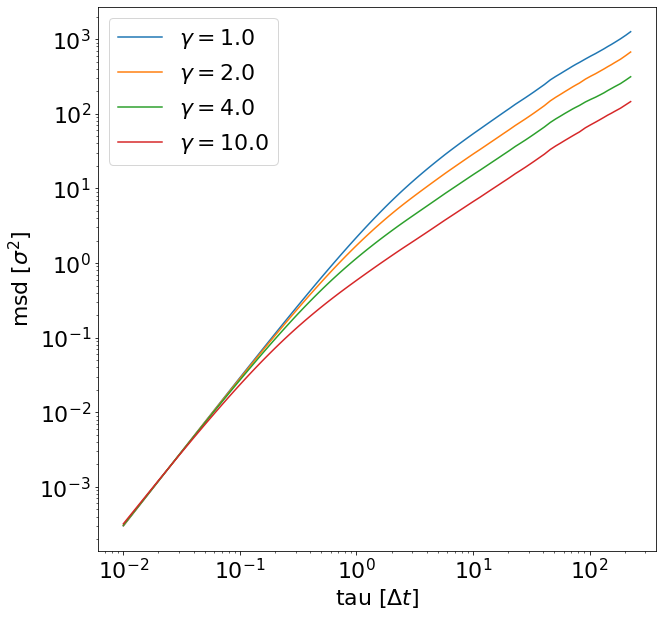

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.ion() # switch on interactive mode

plt.figure(figsize=(10,10))
plt.xlabel('tau [$\Delta t$]')
plt.ylabel('msd [$\sigma^2$]')
for index, r in enumerate(msd_results):
    # adding up componentwise MSDs
    msd = r[1:100, 2] + r[1:100, 3] + r[1:100, 4]
    plt.loglog(r[1:100, 0], msd, label=r"$\gamma=${}".format(str(lb_gammas[index])))
plt.legend()
plt.show()

#### Calculating the diffusion coefficient
In this script an LB fluid and a single particle are created and thermalized. The
random forces on the particle and within the LB fluid will cause the particle to move.
The mean squared displacement is calculated during the simulation via a multiple-tau
correlator. 
Can you give an explanation for the quadratic time dependency for short times? Use the function <tt>curve_fit</tt> from the module <tt>scipy.optimize</tt> to produce a fit for the linear regime and determine the diffusion coefficients for the different $\gamma$s. Calculate the diffusion coefficient for all cases and plot them as a function of γ. What relation do you observe?

## References

[1] S Succi. *The lattice Boltzmann equation for fluid dynamics and beyond. *Clarendon Press, Oxford, 2001.  
[2] B. Dünweg and A. J. C. Ladd. *Advanced Computer Simulation Approaches for Soft Matter Sciences III*, chapter II, pages 89–166. Springer, 2009.  
[3] B. Dünweg, U. Schiller, and A.J.C. Ladd. Statistical mechanics of the fluctuating lattice-boltzmann equation. *Phys. Rev. E*, 76:36704, 2007.  
[4] P. G. de Gennes. *Scaling Concepts in Polymer Physics*. Cornell University Press, Ithaca, NY, 1979.  
[5] M. Doi. *Introduction to Polymer Physics.* Clarendon Press, Oxford, 1996.  
[6] Michael Rubinstein and Ralph H. Colby. *Polymer Physics.* Oxford University Press, Oxford, UK, 2003.  
[7] Daan Frenkel and Berend Smit. *Understanding Molecular Simulation.* Academic Press, San Diego, second edition, 2002.